# Изучение работы с данными (FashionMNIST)
## Реализация моделей классификации изображений

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
#from plotcm import plot_confusion_matrix

import pdb
%matplotlib inline

# Using CUDA

In [9]:
device = torch.device('cuda:0')

# Load and Prepare image Fashion-MNIST


In [57]:
train_data = datasets.FashionMNIST(
    root = 'Dataset/FashionMNIST',
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform=None 
)

test_data = datasets.FashionMNIST(
    root= 'Dataset/FashionMNIST',
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [58]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets) # 60k train data and 10k test

(60000, 60000, 10000, 10000)

In [59]:
#get classes name
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

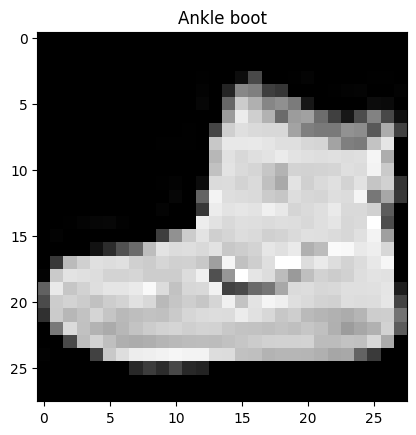

In [60]:
#view image
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

# Add Plot for more image

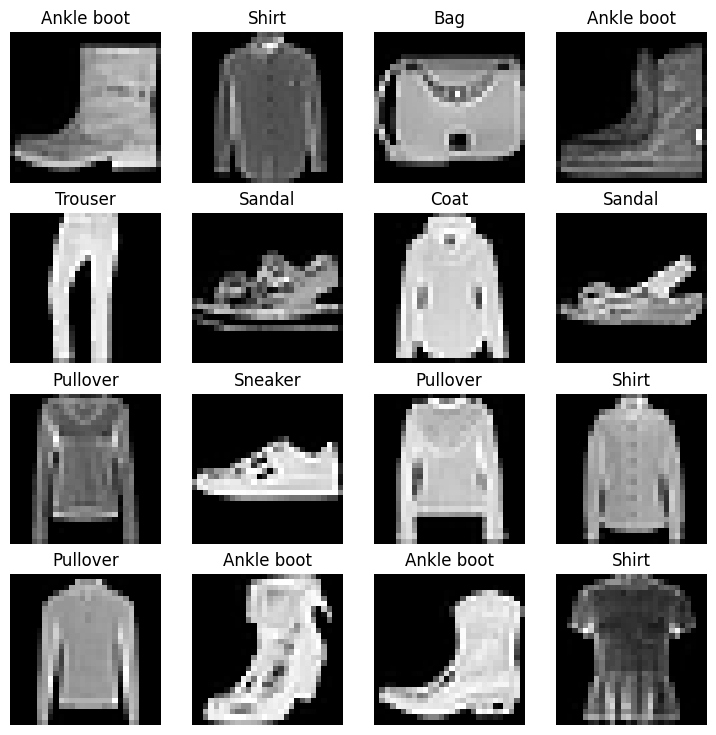

In [61]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4 #count view image 4*4 = 12
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

# Prepare DataLoader

In [65]:
BATCH_SIZE = 32

# create dataset size equals - batchs size and shuffle data
train_dataloader = DataLoader(train_data, 
    batch_size=BATCH_SIZE, 
    shuffle=True 
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # not shuffle for testing data!
)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000233E6FC8460>, <torch.utils.data.dataloader.DataLoader object at 0x00000233E6FC8F70>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [70]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape
print('shapes:', train_features_batch.shape, train_labels_batch.shape)

shapes: torch.Size([32, 1, 28, 28]) torch.Size([32])


Image size: torch.Size([1, 28, 28])
Label: 7, label size: torch.Size([])


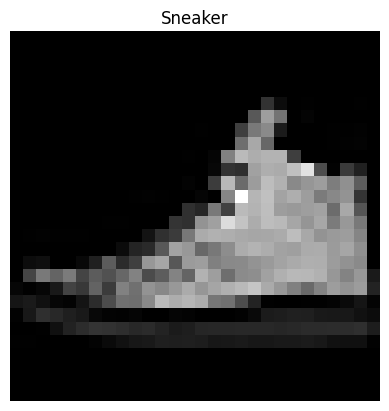

In [71]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

# Create Model V0

In [88]:
# Test Sequential models
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        #input_shape  = 784 (h*w images)
        #hidden_units = his number could be whatever (hidden layer)
        # output_shape=len(class_names)
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # 
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features =  (784 pixels = 28 * 29 px h*w)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [105]:
# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784,
    hidden_units=32, 
    output_shape=len(class_names)
)
model_0.to('cpu') # keep model on CPU/GPU 

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [106]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
 
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [107]:
from helper_functions import accuracy_fn

In [108]:
def compile_model(model, lr):
    loss_fn = nn.CrossEntropyLoss() 
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
    return loss_fn,optimizer

# Create a function to time out experements
Для сравнения времени обучения на CPU и GPU

In [109]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Create training loop

In [112]:
device = 'cpu'

In [113]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")



In [115]:
torch.manual_seed(42)

train_time_start_on_cpu = timer()
epochs = 10
loss_fn,optimizer = compile_model(model_0, 0.001)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

Epoch: 0
---------
Train loss: 1.75083 | Train accuracy: 51.22%
Test loss: 1.33002 | Test accuracy: 63.84%

Epoch: 1
---------
Train loss: 1.13068 | Train accuracy: 66.26%
Test loss: 1.00795 | Test accuracy: 66.74%

Epoch: 2
---------
Train loss: 0.92411 | Train accuracy: 69.15%
Test loss: 0.87840 | Test accuracy: 69.25%

Epoch: 3
---------
Train loss: 0.82412 | Train accuracy: 71.92%
Test loss: 0.80493 | Test accuracy: 71.69%

Epoch: 4
---------
Train loss: 0.76151 | Train accuracy: 74.02%
Test loss: 0.75467 | Test accuracy: 73.62%

Epoch: 5
---------
Train loss: 0.71685 | Train accuracy: 75.48%
Test loss: 0.71679 | Test accuracy: 74.82%

Epoch: 6
---------
Train loss: 0.68254 | Train accuracy: 76.72%
Test loss: 0.68697 | Test accuracy: 75.92%

Epoch: 7
---------
Train loss: 0.65512 | Train accuracy: 77.80%
Test loss: 0.66387 | Test accuracy: 76.74%

Epoch: 8
---------
Train loss: 0.63264 | Train accuracy: 78.61%
Test loss: 0.64353 | Test accuracy: 77.70%

Epoch: 9
---------
Train los

# Create functions predictions eval

In [131]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device: torch.device = device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}



In [117]:
# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.6272459626197815,
 'model_acc': 77.99520766773163}

In [125]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Create Model V1

In [126]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [127]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, 
    hidden_units=32,
    output_shape=len(class_names) 
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

In [129]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 10
loss_fn,optimizer = compile_model(model_1, 0.001)
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device = device
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device = device
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

Epoch: 0
---------
Train loss: 1.26085 | Train accuracy: 62.06%
Test loss: 1.21176 | Test accuracy: 62.81%

Epoch: 1
---------
Train loss: 1.16643 | Train accuracy: 63.84%
Test loss: 1.14025 | Test accuracy: 64.66%

Epoch: 2
---------
Train loss: 1.10525 | Train accuracy: 66.01%
Test loss: 1.09045 | Test accuracy: 66.56%

Epoch: 3
---------
Train loss: 1.06012 | Train accuracy: 67.61%
Test loss: 1.05251 | Test accuracy: 68.25%

Epoch: 4
---------
Train loss: 1.02478 | Train accuracy: 68.88%
Test loss: 1.02220 | Test accuracy: 69.10%

Epoch: 5
---------
Train loss: 0.99641 | Train accuracy: 69.72%
Test loss: 0.99801 | Test accuracy: 69.59%

Epoch: 6
---------
Train loss: 0.97325 | Train accuracy: 70.25%
Test loss: 0.97754 | Test accuracy: 70.15%

Epoch: 7
---------
Train loss: 0.95410 | Train accuracy: 70.70%
Test loss: 0.96074 | Test accuracy: 70.50%

Epoch: 8
---------
Train loss: 0.93814 | Train accuracy: 71.06%
Test loss: 0.94665 | Test accuracy: 70.76%

Epoch: 9
---------
Train los

In [132]:
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.9355453252792358,
 'model_acc': 71.05630990415335}

In [133]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.6272459626197815,
 'model_acc': 77.99520766773163}

# Create CNN Models

In [134]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
           
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


In [135]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [137]:
loss_fn,optimizer = compile_model(model_2, 0.001)

In [139]:
train_time_start_model_2 = timer()

# Train and test model 
epochs = 10
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

Epoch: 0
---------
Train loss: 2.29635 | Train accuracy: 10.47%
Test loss: 2.28264 | Test accuracy: 13.33%

Epoch: 1
---------
Train loss: 1.78213 | Train accuracy: 40.53%
Test loss: 0.89443 | Test accuracy: 65.35%

Epoch: 2
---------
Train loss: 0.79986 | Train accuracy: 70.31%
Test loss: 0.79883 | Test accuracy: 72.39%

Epoch: 3
---------
Train loss: 0.72747 | Train accuracy: 73.83%
Test loss: 0.72825 | Test accuracy: 72.86%

Epoch: 4
---------
Train loss: 0.68687 | Train accuracy: 75.39%
Test loss: 0.66279 | Test accuracy: 76.19%

Epoch: 5
---------
Train loss: 0.65481 | Train accuracy: 76.46%
Test loss: 0.65350 | Test accuracy: 76.42%

Epoch: 6
---------
Train loss: 0.62810 | Train accuracy: 77.32%
Test loss: 0.64707 | Test accuracy: 75.85%

Epoch: 7
---------
Train loss: 0.60518 | Train accuracy: 78.11%
Test loss: 0.61169 | Test accuracy: 77.85%

Epoch: 8
---------
Train loss: 0.58615 | Train accuracy: 78.82%
Test loss: 0.58562 | Test accuracy: 79.17%

Epoch: 9
---------
Train los

In [140]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.581453263759613,
 'model_acc': 79.22324281150159}

# Compare model results and training time

In [141]:
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.627246,77.995208
1,FashionMNISTModelV1,0.935545,71.056310
2,FashionMNISTModelV2,0.581453,79.223243


In [142]:
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.627246,77.995208,90.317249
1,FashionMNISTModelV1,0.935545,71.056310,124.647375
2,FashionMNISTModelV2,0.581453,79.223243,150.901472


Exception ignored in: <function tqdm.__del__ at 0x00000233E654F880>
Traceback (most recent call last):
  File "C:\Users\Tosch\anaconda3\envs\tf\lib\site-packages\tqdm\std.py", line 1145, in __del__
    self.close()
  File "C:\Users\Tosch\anaconda3\envs\tf\lib\site-packages\tqdm\notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


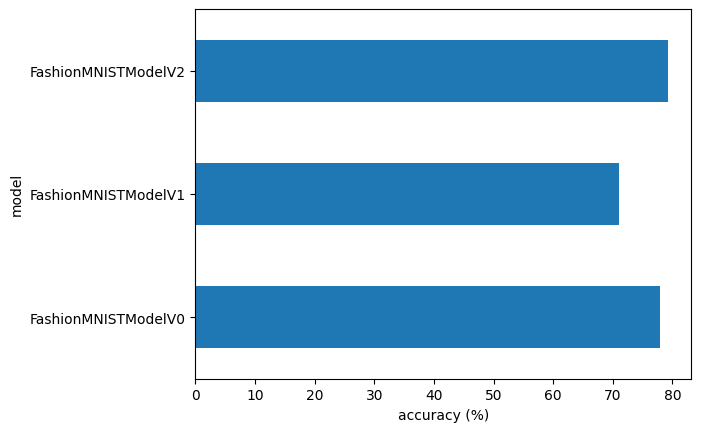

In [143]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

# Make and evaluate random predictions

In [144]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [149]:
import random
random.seed(41)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 4 (Coat)


In [150]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2, 
                             data=test_samples)

# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([3, 0, 2, 8, 2, 7, 4, 0, 1])

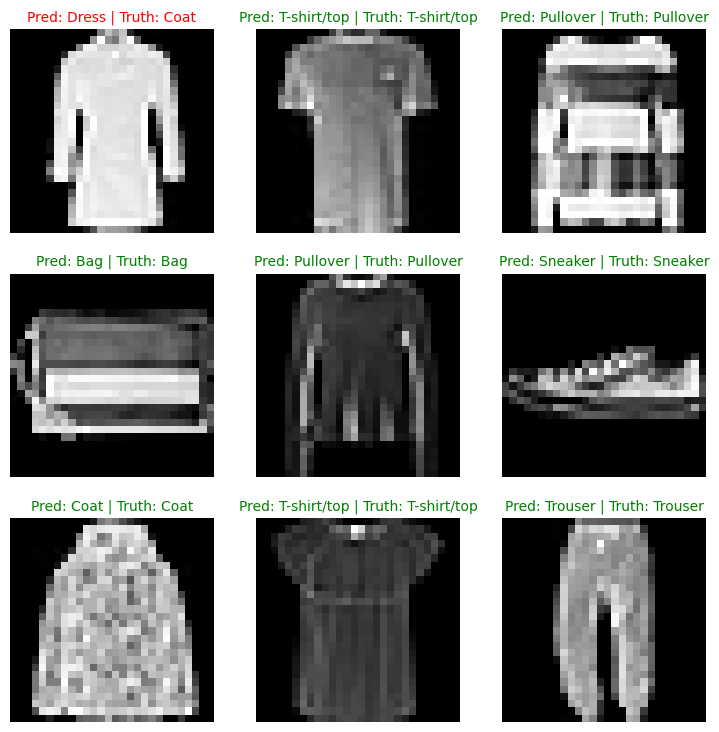

In [151]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [152]:
from tqdm.auto import tqdm

In [160]:
y_preds = []
model_2.eval()
with torch.inference_mode(): # get predict data
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|███████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 173.45it/s]


In [161]:
import torchmetrics, mlxtend

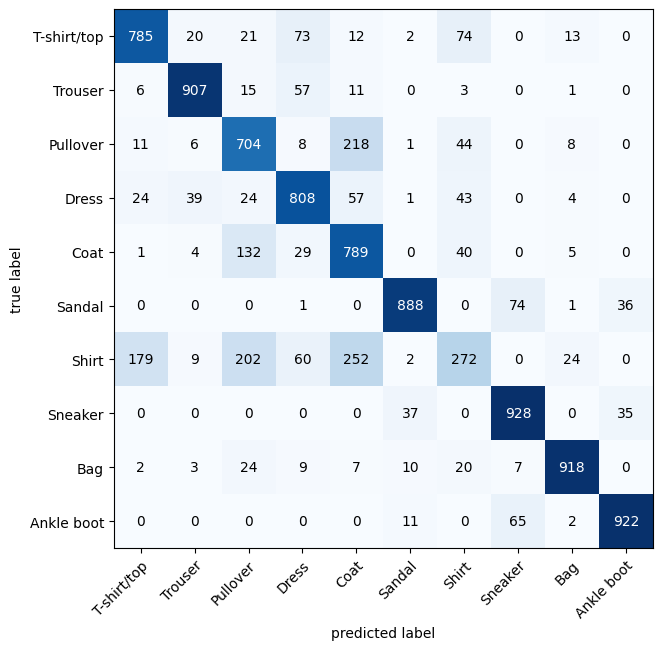

In [162]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);


# Save and load models

In [164]:
from pathlib import Path

In [168]:
MODEL_PATH = Path("F:\Git_Clone\Learning-Pytorch\Models")
MODEL_NAME = "pytorch_computer_vision_model_CNN_V2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: F:\Git_Clone\Learning-Pytorch\Models\pytorch_computer_vision_model_CNN_V2.pth


In [169]:
#create model and load weights

loaded_model_2 = FashionMNISTModelV2(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

In [170]:
loaded_model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [171]:
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.581453263759613,
 'model_acc': 79.22324281150159}